In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
pd.options.mode.chained_assignment = None

stock_data = pd.read_csv('..\source\dfnew_clean.csv')
model = load_model('..\save\BEST-2.h5')

In [2]:
target = ['Close']
features = ['Transaction','Open', 'High', 'Low','TrustNet']
df = stock_data[features + target]
split = int(df.shape[0] * 0.8)
df_test = df.iloc[split:, :].copy()

In [3]:
target_scaler = MinMaxScaler().fit(df_test[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_test[features])
df_test[features] = features_scaler.transform(df_test[features])

In [4]:
# extract the input sequences and output values
sequence_length = 5

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)

(486, 5, 6)


In [19]:
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
res=pd.concat([stock_data['DateTime'],df],axis=1)
test=res[['DateTime','Open','Close', 'Predicted']].dropna().reset_index(drop=True)
test

16/16 [==============================] - 0s 2ms/step


,DateTime,Open,Close,Predicted
0,2021-01-08,580.0,580.0,539.076660
1,2021-01-11,577.0,584.0,548.077271
2,2021-01-12,583.0,591.0,558.124451
3,2021-01-13,595.0,605.0,569.626526
4,2021-01-14,587.0,592.0,580.159729
...,...,...,...,...
481,2022-12-26,454.0,456.5,462.934448
482,2022-12-27,458.0,457.0,460.770782
483,2022-12-28,451.0,451.0,460.270264
484,2022-12-29,444.0,446.0,459.051453


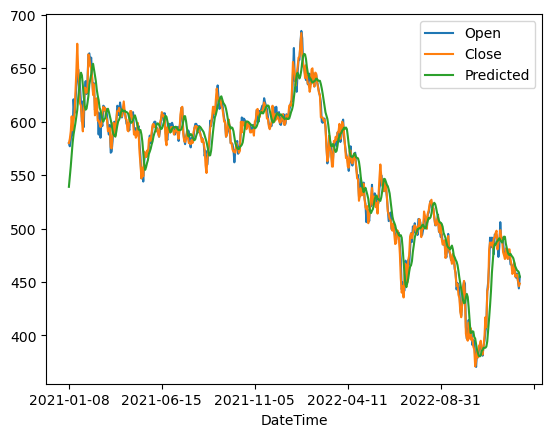

In [20]:
plot=test.plot(x='DateTime')
fig = plot.get_figure()

In [21]:
test.loc[test.Close.shift(1) >= test.Close, "Trend"]= 0
test.loc[test.Close.shift(1) < test.Close, "Trend"]= 1
test['Trend']=test['Trend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Predicted, "PredTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Predicted, "PredTrend"]= 1
test['PredTrend']=test['PredTrend'].fillna(0).astype(int)
test.loc[test.Predicted.shift(1) >= test.Close.shift(1), "PredvsTrend"]= 0
test.loc[test.Predicted.shift(1) < test.Close.shift(1), "PredvsTrend"]= 1
test['PredvsTrend']=test['PredvsTrend'].fillna(0).astype(int)


test['status'] = test.PredTrend.shift(1).fillna(0).astype(int)
test['status2']=test.status
test.loc[( (test.status.shift(1)==0) & (test.status==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 0
test.loc[( (test.status.shift(1)==1) & (test.status==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status2"]= 1
# test['status2']=test['status2'].fillna(0).astype(int)
# test['status2']=test['status2']

# 做一條predict的均線試看看

test['status3']= test.PredvsTrend.shift(1).fillna(0).astype(int)
test.loc[( (test.PredvsTrend.shift(1)==0) & (test.PredvsTrend==1) ) & (test.Close.shift(1)<=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 0
test.loc[( (test.PredvsTrend.shift(1)==1) & (test.PredvsTrend==0) ) & (test.Close.shift(1)>=test.Close.shift(2)) & (test.Open <= test.Close.shift(1)) , "status3"]= 1



# .shift(1)是前一個

test['buy_cost'] = test.Open[np.where((test.status3 == 1) * (test.status3.shift(1) == 0))[0]]
test['sell_cost'] = test.Open[np.where((test.status3 == 0) * (test.status3.shift(1) == 1))[0]]

test = test.fillna(0)
buy_cost = np.array(test.buy_cost[test.buy_cost != 0])
sell_price = np.array(test.sell_cost[test.sell_cost != 0])

if len(buy_cost) > len(sell_price) :
    buy_cost = buy_cost[:-1]

trade_return = sell_price / buy_cost - 1
fee = 0.002
net_trade_return = trade_return - fee

test['trade_ret'] = 0
test['net_trade_ret'] = 0
sell_dates = test.sell_cost[test.sell_cost != 0].index
test.loc[sell_dates, 'trade_ret'] = trade_return
test.loc[sell_dates, 'net_trade_ret'] = net_trade_return

test['open_ret'] = test.Open / test.Open.shift(1) - 1
test['strategy_ret'] = test.status.shift(1) * test.open_ret
test['strategy_net_ret'] = test.strategy_ret
test.loc[sell_dates, 'strategy_net_ret'] = test.loc[sell_dates, 'strategy_net_ret'] - fee
test = test.fillna(0)

test['buy_and_hold_equity'] = (test.open_ret + 1).cumprod()
test['strategy_equity'] = (test.strategy_ret + 1).cumprod()
test['strategy_net_equity'] = (test.strategy_net_ret + 1).cumprod()

test

,DateTime,Open,Close,Predicted,Trend,PredTrend,PredvsTrend,status,status2,status3,buy_cost,sell_cost,trade_ret,net_trade_ret,open_ret,strategy_ret,strategy_net_ret,buy_and_hold_equity,strategy_equity,strategy_net_equity
0,2021-01-08,580.0,580.0,539.076660,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
1,2021-01-11,577.0,584.0,548.077271,1,1,1,0,0,0,0.0,0.0,0.0,0.0,-0.005172,-0.000000,-0.000000,0.994828,1.000000,1.000000
2,2021-01-12,583.0,591.0,558.124451,1,1,1,1,1,1,583.0,0.0,0.0,0.0,0.010399,0.000000,0.000000,1.005172,1.000000,1.000000
3,2021-01-13,595.0,605.0,569.626526,1,1,1,1,1,1,0.0,0.0,0.0,0.0,0.020583,0.020583,0.020583,1.025862,1.020583,1.020583
4,2021-01-14,587.0,592.0,580.159729,0,1,1,1,1,1,0.0,0.0,0.0,0.0,-0.013445,-0.013445,-0.013445,1.012069,1.006861,1.006861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-12-26,454.0,456.5,462.934448,1,0,0,0,0,0,0.0,0.0,0.0,0.0,-0.007650,-0.000000,-0.000000,0.782759,1.127831,1.030801
482,2022-12-27,458.0,457.0,460.770782,1,0,0,0,0,0,0.0,0.0,0.0,0.0,0.008811,0.000000,0.000000,0.789655,1.127831,1.030801
483,2022-12-28,451.0,451.0,460.270264,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-0.015284,-0.000000,-0.000000,0.777586,1.127831,1.030801
484,2022-12-29,444.0,446.0,459.051453,0,0,0,0,0,0,0.0,0.0,0.0,0.0,-0.015521,-0.000000,-0.000000,0.765517,1.127831,1.030801


Text(0, 0.5, 'strategy_equity')

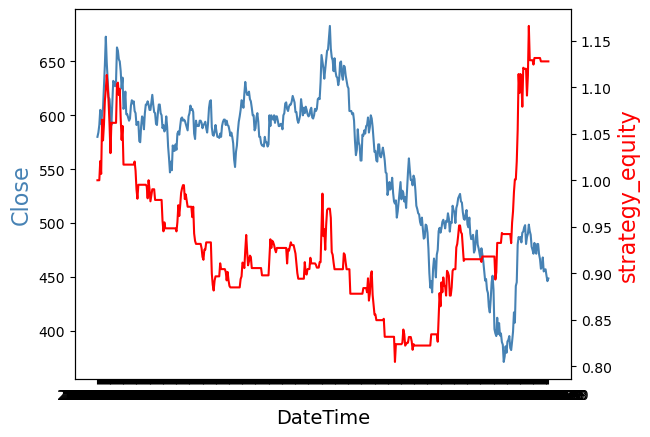

In [22]:
import matplotlib.pyplot as plt
col1 = 'steelblue'
col2 = 'red'
col3 = 'green'
fig2,ax = plt.subplots()
ax.plot(test.DateTime, test.Close, color=col1)
ax.set_xlabel('DateTime', fontsize=14)
ax.set_ylabel('Close', color=col1, fontsize=16)
ax2 = ax.twinx()
ax2.plot(test.DateTime, test.strategy_equity, color=col2)
ax2.set_ylabel('strategy_equity', color=col2, fontsize=16)